In [4]:
#!pip install scikit-learn
#!pip install matplotlib

  Using cached scipy-1.14.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
    --------------------------------------- 0.3/10.9 MB ? eta -:--:--
   ---------- ----------------------------- 2.9/10.9 MB 10.5 MB/s eta 0:00:01
   ---------------------------------------- 10.9/10.9 MB 23.6 MB/s eta 0:00:00
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.14.0-cp312-cp312-win_amd64.whl (44.5 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [5]:
import duckdb
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import os
import matplotlib.pyplot as plt


In [52]:
# Establecer el directorio de trabajo
os.chdir("G:/Mi unidad/01-Maestria Ciencia de Datos/DMEyF")
# Conectar a la base de datos y leer los datos
conn = duckdb.connect('DMEyF2024.duckdb')
#dataset = conn.execute("SELECT * FROM competencia").fetchdf()


In [53]:
# Leer el archivo CSV y crear la tabla en la base de datos
conn.execute("""
    CREATE TABLE competencia01 AS 
    SELECT * FROM read_csv_auto('competencia_01_crudo.csv')
""")

In [54]:
# Listar todas las tablas en la base de datos
tables = conn.execute("SHOW TABLES").fetchdf()
print(tables)

            name
0    competencia
1  competencia01


In [55]:
# Reemplaza 'nombre_de_tu_tabla' por el nombre de la tabla que deseas consultar
columnas = conn.execute("""
    SELECT column_name
    FROM information_schema.columns
    WHERE table_name = 'competencia01'
""").fetchdf()

print(columnas)

                 column_name
0          numero_de_cliente
1                   foto_mes
2             active_quarter
3                cliente_vip
4                   internet
..                       ...
149           Visa_fechaalta
150       Visa_mconsumototal
151           Visa_cconsumos
152  Visa_cadelantosefectivo
153         Visa_mpagominimo

[154 rows x 1 columns]


# 2.- Carga de clase_ternaria

In [60]:
# Verificar si la columna 'clase_ternaria' existe en la tabla 'competencia01'
column_exists = conn.execute("""
    SELECT COUNT(*) 
    FROM information_schema.columns 
    WHERE table_name = 'competencia01' 
    AND column_name = 'clase_ternaria';
""").fetchone()[0]

# Si la columna existe, se procede a eliminarla
if column_exists > 0:
    conn.execute("ALTER TABLE competencia01 DROP COLUMN clase_ternaria;")

conn.execute("ALTER TABLE competencia01 ADD COLUMN clase_ternaria TEXT;")

# Ejecutar la consulta para convertir foto_mes a una fecha en formato AAAAMMDD
conn.execute("""
    UPDATE competencia01
    SET foto_mes = STRFTIME('%Y-%m-%d', foto_mes || '01')
""")


conn.execute("""
UPDATE competencia01 AS c1
SET clase_ternaria = 'CONTINUA'
WHERE EXISTS (
    SELECT 1
    FROM competencia01 AS c2
    WHERE c1.numero_de_cliente = c2.numero_de_cliente
    AND c2.foto_mes = c1.foto_mes + 2
);
""")

# BAJA+1: Si no hay un registro en el siguiente mes
conn.execute("""
UPDATE competencia01 AS c1
SET clase_ternaria = 'BAJA+1'
WHERE clase_ternaria IS NULL
AND NOT EXISTS (
    SELECT 1
    FROM competencia01 AS c2
    WHERE c1.numero_de_cliente = c2.numero_de_cliente
    AND c2.foto_mes = c1.foto_mes + 1
);
""")

# BAJA+2: Si no hay un registro en los próximos dos meses
conn.execute("""
UPDATE competencia01 AS c1
SET clase_ternaria = 'BAJA+2'
WHERE clase_ternaria IS NULL
AND NOT EXISTS (
    SELECT 1
    FROM competencia01 AS c2
    WHERE c1.numero_de_cliente = c2.numero_de_cliente
    AND c2.foto_mes = c1.foto_mes + 2
);
""")

# Ejecutar la consulta para actualizar la columna 'clase_ternaria'
conn.execute("""
    UPDATE competencia01
    SET clase_ternaria = 0
    WHERE foto_mes IN ('202105', '202106');
""")



In [62]:
query = """
SELECT 
    foto_mes,
    SUM(CASE WHEN clase_ternaria = 'CONTINUA' THEN 1 ELSE 0 END) AS CONTINUA,
    SUM(CASE WHEN clase_ternaria = 'BAJA+1' THEN 1 ELSE 0 END) AS BAJA_1,
    SUM(CASE WHEN clase_ternaria = 'BAJA+2' THEN 1 ELSE 0 END) AS BAJA_2
FROM 
    competencia01
GROUP BY 
    foto_mes
ORDER BY 
    foto_mes;
"""
# Ejecutar la consulta y almacenar el resultado en un DataFrame
conteo_foto_mes = conn.execute(query).fetchdf()

# Mostrar el resultado
print(conteo_foto_mes)



   foto_mes  CONTINUA  BAJA_1  BAJA_2
0    202101  160606.0   635.0   785.0
1    202102  160844.0   785.0  1017.0
2    202103  161684.0  1020.0   981.0
3    202104  161919.0   982.0  1189.0
4    202105       0.0     0.0     0.0
5    202106       0.0     0.0     0.0


# 3.- Entrenamiento de Modelo

In [66]:
dataset = conn.execute("SELECT * FROM competencia01").fetchdf()

In [67]:
dtrain = dataset[dataset['foto_mes'] <= 202104]
dapply = dataset[dataset['foto_mes'] == 202106]


In [68]:
# Definir el modelo
modelo = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    min_samples_split=250,
    min_samples_leaf=100,
    max_depth=7,
    random_state=42
)

# Entrenar el modelo
X_train = dtrain.drop(columns=['clase_ternaria'])  # Variables predictoras
y_train = dtrain['clase_ternaria']  # Variable objetivo

modelo.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=7, min_samples_leaf=100, min_samples_split=250,
                       random_state=42)

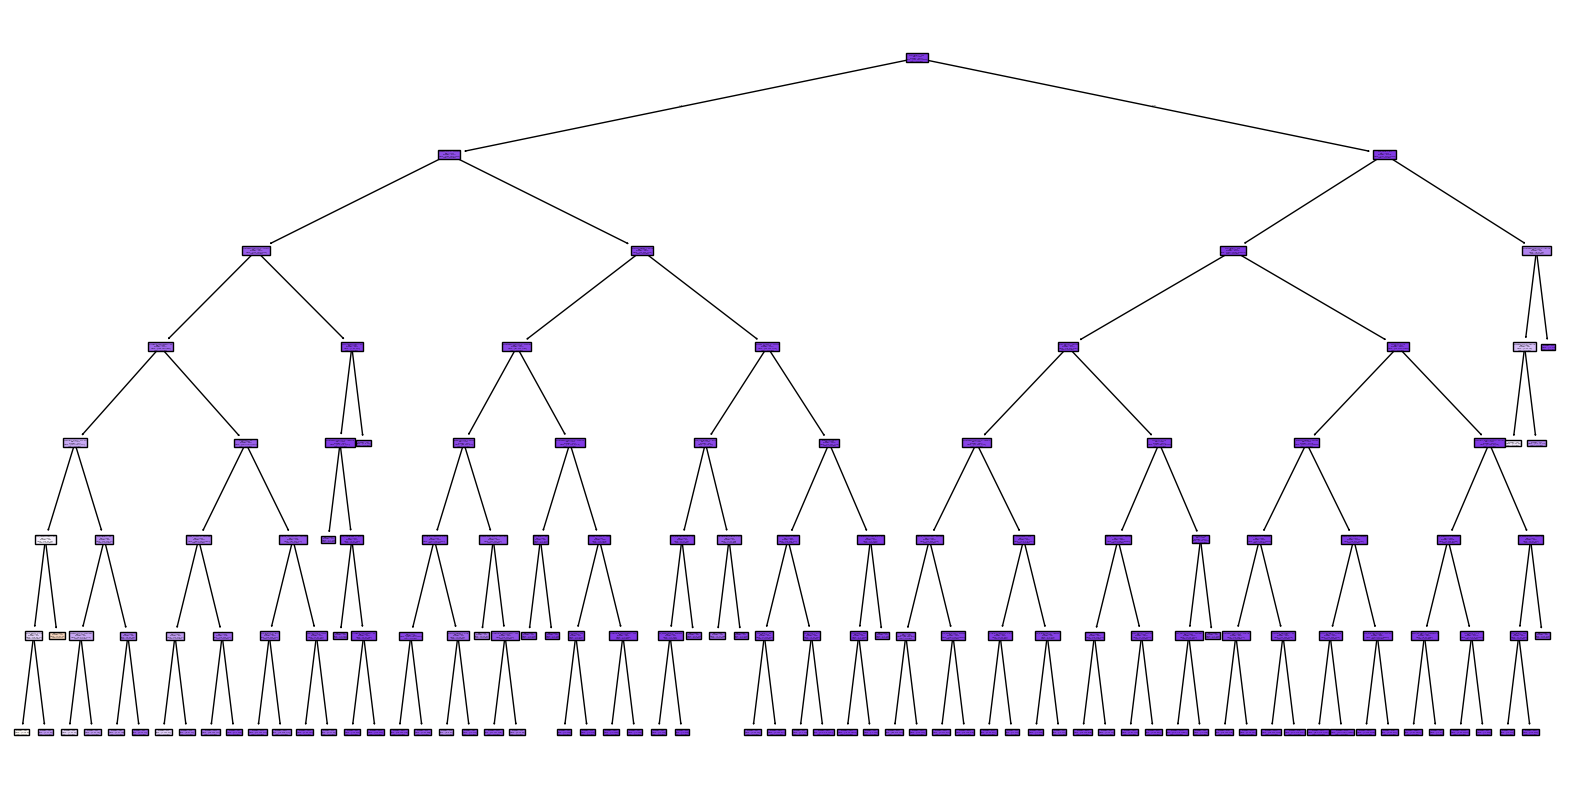

In [69]:
#Graficar Arbol
plt.figure(figsize=(20, 10))
plot_tree(modelo, feature_names=X_train.columns, class_names=modelo.classes_, filled=True)
plt.show()


In [70]:
print(dtrain.shape)  # Debería mostrar el número de filas y columnas
print(dtrain.head())  # Mostrar los primeros registros para verificar


(652447, 155)
   numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
0          249221109    202101               1            0         0   
1          249221468    202101               1            0         0   
2          249223005    202101               1            0         0   
3          249228180    202101               1            0         0   
4          249232117    202101               1            0         0   

   cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
0            61                 300        1664.94              17994.40   
1            53                  37        4879.78              18640.95   
2            48                 202        1828.35              37789.01   
3            66                 320         175.87               2600.67   
4            79                 373       16600.69              32270.07   

   mcomisiones  ...  Visa_fultimo_cierre  Visa_mpagado  Visa_mpagospesos  \
0      1605.81

In [71]:
# Realizar la predicción
prediccion = modelo.predict_proba(dapply.drop(columns=['clase_ternaria']))


In [50]:
# Agregar la columna prob_baja2
dapply['prob_baja2'] = prediccion[:, modelo.classes_.tolist().index('BAJA+2')]

# Calcular la columna Predicted
dapply['Predicted'] = (dapply['prob_baja2'] > 1/40).astype(int)


C:\Users\tschoppj\AppData\Local\Temp\ipykernel_28092\650192999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dapply['prob_baja2'] = prediccion[:, modelo.classes_.tolist().index('BAJA+2')]
C:\Users\tschoppj\AppData\Local\Temp\ipykernel_28092\650192999.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dapply['Predicted'] = (dapply['prob_baja2'] > 1/40).astype(int)


In [51]:
# Crear directorios
os.makedirs("./exp/KA2001", exist_ok=True)

# Exportar los resultados
dapply[['numero_de_cliente', 'Predicted']].to_csv("./exp/KA2001/K101_001.csv", index=False, sep=',')
